In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd 'drive/My Drive/Development/Biometrics'

/content/drive/My Drive/Development/Biometrics


![title](logo.png)

# Biometrics System Concepts

## Assignment 1: Fingerprint Recognition

Implement and test a key-point based fingerprint recognition/verification system.

A high-level description is provided with links to or hints of code snippets and libraries that you can reuse/adapt at your will (with proper referencing!).

The following steps need to be implemented:
1. Importing the required packages
2. Reading image data, conversion to gray-scale
3. Preprocessing: Enhancement using orientation/frequency filtering and Segmentation of foreground 
4. "Minutiae" detection using keypoint detectors and descriptors from OpenCV
5. Matching using keypoint matching
6. **Validation using a verification and identification scenario** (cf. previous assignment)

For steps 1-5, code examples will be provided below. You can and are invited to adapt these at your will (different parameter settings, different choices of algorithmic components). 

### 1. Importing packages

In [6]:
!pip install pyeer

In [0]:
import cv2 # OpenCV
import numpy as np # Array processing
import matplotlib.pyplot as plt # Plotting
%matplotlib inline
from pathlib import Path # File path processing
import fprmodules.enhancement as fe # Fingerprint enhancement
import pyeer # Simple biometric metrics
from sklearn.metrics import roc_curve
import pickle # Save and read intermediate results
from tqdm.notebook import tqdm as tqdm_notebook # Visual progress bar

In [0]:
# Select database
DB = 1

### 2. Reading image data and conversion to gray scale

We will make use of the Fingerprint Verification Competition'2002 Database ([FVC'2002](http://bias.csr.unibo.it/fvc2002/default.asp)) images. This was the second in a series of benchmark tests that were made publically available. While we do not have access to the full (880 images) database, you can test your algorithm on a subset of 80 images (10 individuals/fingers, 8 fingerprints per finger). Eventually, you can compare your results to the results that other competitors have uploaded. 

In [6]:
# Read a whole database, stored in a single folder with filenames as 
#   XXY.tif with XX the individual number and Y the fingerprint number 
#   for this individual returns a list of images and a list of associated 
#   identity labels.
def read_database(path):
    images = []
    labels = []
    imagePaths = sorted(Path(path).rglob("*.tif"))
    for imagePath in tqdm_notebook(imagePaths):
        image = cv2.imread(path + imagePath.name)
        if (len(image.shape) > 2):
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        images.append(image)
        label = imagePath.stem[1:3]
        labels.append(label)
    return (images, labels)

images, labels = read_database('./fprdata/FVC2002/DB' + str(DB) + '_B/')

(374, 388)


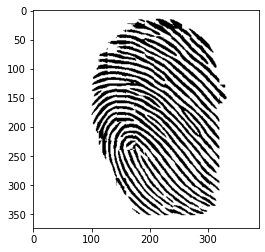

In [7]:
# Verify by showing some images
print(images[0].shape)
plt.imshow(images[0],cmap='gray')
plt.show()

### 3. Preprocessing: enhancement using ridge orientation/frequency estimation and segmentation of foreground

We will re-use code developed by [Utkarsh Deshmukh](https://github.com/Utkarsh-Deshmukh/Fingerprint-Enhancement-Python), which is a Python-recode of Matlab-code developed by [Peter Kovesi](https://www.peterkovesi.com/matlabfns/index.html#fingerprints). I have slightly adapted this code to make it more compliant with OpenCV. 

It uses gradient-based orientation and local frequency estimation as input to an orientation and frequency selective filtering using a Gabor filterbank. 

At the same time a foreground region segmentation (mask) is determined by calculating the standard deviation in local windows and thresholding above a certain level. 

In [0]:
# Calculate the enhanced images and the associated segmentation masks
def enhance_images(images):
    images_e_u = []
    masks = []
    for i, image in enumerate(tqdm_notebook(images)):
        try:
            # Gabor filtering
            img_e, mask, orientim, freqim = fe.image_enhance(image)
            # Normalize in the [0,255] range
            img_e_u = cv2.normalize(img_e, 
                                    None, 
                                    alpha=0, 
                                    beta=255, 
                                    norm_type=cv2.NORM_MINMAX, 
                                    dtype=0)
            images_e_u.append(img_e_u)
        except:
            print('error for: ', i)
            images_e_u.append(image)
        masks.append(mask)
    return images_e_u, masks

images_enhanced, masks = enhance_images(images)

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/content/drive/My Drive/Development/Biometrics/fprmodules/enhancement/ridge_filter.py:61: RuntimeWarning: invalid value encountered in greater
  ind = np.where(freq_1d>0);


error for:  3
error for:  5
error for:  6
error for:  8
error for:  9
error for:  10


In [0]:
# Intermediate (computation heavy) results can be saved on file 
#   using the pickle package.
# This is commented out to not overwrite previously saved data.
#p_file = open( "./fprdata/DB" + str(DB) + "_enhanced.p", "wb" )
#pickle.dump([images_enhanced, labels, masks], p_file)

In [0]:
# And read back for further processing
p_file = open( "./fprdata/DB" + str(DB) + "_enhanced.p", "rb" )
[images_enhanced, labels, masks] = pickle.load(p_file)

<Figure size 432x288 with 0 Axes>

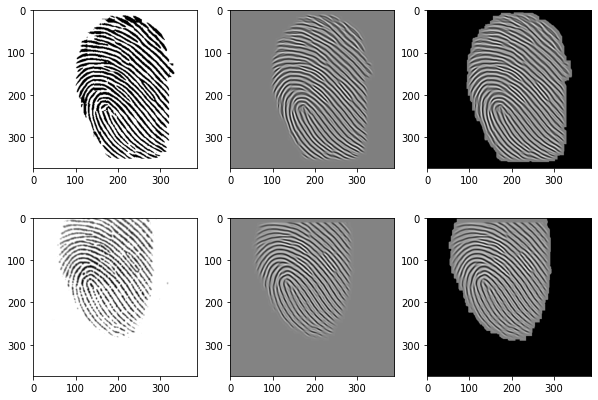

In [9]:
# Verify by showing some input and processed images
ax = plt.figure()
fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize=(10,7))
ax[0,0].imshow(images[0], cmap='gray')
ax[0,1].imshow(images_enhanced[0], cmap='gray')
ax[0,2].imshow(images_enhanced[0] * masks[0], cmap='gray')
ax[1,0].imshow(images[1], cmap='gray')
ax[1,1].imshow(images_enhanced[1], cmap='gray')
ax[1,2].imshow(images_enhanced[1] * masks[1], cmap='gray')
plt.show()

### 4. Keypoint Extraction and matching
The basis/traditional fingerprint matching algorithm is based on matching keypoints, called minutiae. They are defined as the ridge endings and bifurcations and can be determined by first thresholding the FP image and skeletonizing/thinning the enhanced image. For those really interested (but not part of this assignment) in experimenting with such an approach, some code is provided in the fprmodules/minutiae_extraction folder.

Instead, we will rely on establised methods developed in Computer Vision, where the use of keypoint features has proven to be very succesfull (prior to the advent of Deep Learning) in image classification, image alignment and object recognition tasks.

In this assignment, you are encouraged to try out a series of detection/description/matching algorithms. A short overview of these methods can be found in the OpenCV documentation: [keypoint_detection_descrption_matching](https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_feature2d/py_table_of_contents_feature2d/py_table_of_contents_feature2d.html#py-table-of-content-feature2d).
Please read these pages carefully and try to understand these methods.

#### 4.1 Keypoint detection and feature description

Below, you find one example, that uses ORB features. You can experiment with other feature descriptors and [matching routines](https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_feature2d/py_matcher/py_matcher.html#matcher) as presented on these pages.

In this template code, we detect and describe keypoints and features. You can test the whole procedure for different detectors. We expect that the keypoints will be detected at "interesting" locations, where locally things seem to change drastically (endings, bifurcations, cores, deltas ...) 

In [0]:
# Pick a detector/descriptor
dd_name = 'BRIEF' # ORB | SIFT | SURF | BRISK | BRIEF
dd_norm = cv2.NORM_HAMMING
if dd_name == 'SIFT' or dd_name == 'SURF':
  dd_norm = cv2.NORM_L1

In [0]:
# Call keypoint detector and descriptor.
#   This can be supplemented with other detectors.
def detect_keypoints(image, dd_name=dd_name):
    max_results = 500
    dd = cv2.ORB_create(max_results)
    if dd_name == 'SIFT':
      dd = cv2.xfeatures2d.SIFT_create(max_results)
    elif dd_name == 'SURF':
      dd = cv2.xfeatures2d.SURF_create(max_results)
    #elif descriptor_name == 'FAST':
      #cv2.FastFeatureDetector_create()
    elif dd_name == 'BRIEF':
      star = cv2.xfeatures2d.StarDetector_create()
      brief = cv2.xfeatures2d.BriefDescriptorExtractor_create()
      kp = star.detect(image, None)
      return brief.compute(image, kp)
    elif dd_name == 'BRISK':
      dd = cv2.BRISK_create();
    else:
      return null
    return dd.detectAndCompute(image, None)

In [0]:
# Install opencv-contrib if SIFT/SURF is being used.
!pip uninstall opencv-python
!pip uninstall opencv-contrib-python
!pip install opencv-python==3.4.2.16
!pip install opencv-contrib-python==3.4.2.16

In [0]:
# Many false keypoints will be generated at the edge of the 
#   foreground mask, since ridges seem to terminate due to the clipping.
#   We remove these by a morpholigical erosion (shrinking) 
#   of the foreground mask and deleting the keypoints outside.
def remove_edge_kps(mask, kp, desc):
    mask_b = mask.astype(np.uint8)  #convert to an unsigned byte
    # morphological erosion
    mask_b *= 255
    mask_e = cv2.erode(mask_b, 
                       kernel = np.ones((5,5),np.uint8), 
                       iterations = 5)
    # remove keypoints and their descriptors that lie outside this 
    #   eroded mask
    kpn = [kp[i] 
            for i in range(len(kp)) 
            if mask_e.item(int(kp[i].pt[1]), 
                           int(kp[i].pt[0])) == 255
    ]
    descn = np.vstack([desc[i] 
                        for i in range(len(kp)) 
                        if mask_e.item(int(kp[i].pt[1]), 
                                       int(kp[i].pt[0])) == 255
    ])
    return kpn, descn

<Figure size 432x288 with 0 Axes>

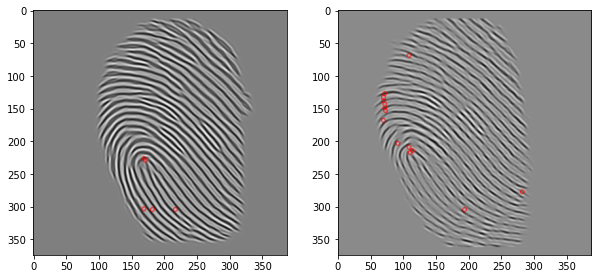

In [85]:
def find_keypoints(image, mask):
  # detect keypoints and generate descriptors for the image.
  kp, des = detect_keypoints(image)
  kp, des = remove_edge_kps(mask, kp, des)
  return kp, des

def draw_keypoints(image, kp):
  # draw keypoints on the image
  return cv2.drawKeypoints(image, 
                           kp, 
                           None, 
                           (255, 0, 0), 
                           cv2.DRAW_MATCHES_FLAGS_DEFAULT)

# Find keypoints and generate descriptors
test_nr_1 = 0
test_nr_2 = 7
image_enhanced_1 = images_enhanced[test_nr_1]
image_enhanced_2 = images_enhanced[test_nr_2]
kp1, des1 = find_keypoints(image_enhanced_1, masks[test_nr_1])
kp2, des2 = find_keypoints(image_enhanced_2, masks[test_nr_2])

# Visualise the keypoints
ax = plt.figure()
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(10,10))
ax[0].imshow(draw_keypoints(image_enhanced_1, kp1))
ax[1].imshow(draw_keypoints(image_enhanced_2, kp2))
plt.show()

#### 4.2 Local Matching by feature vector comparison

Once all images have been processed we can start matching the keypoints between the images. 

We can do this on a purely **local level** by comparing the feature decriptors in one image with the feature descriptors in the other image. Note that these feature descriptors give a vectorial summary of the neighbourhood around each keypoint. A simple metric on these vectors (Euclidean Distance for continuous variables, Hamming Distance for binary variables) can then be used to determine similarity. 

A simple Brute Force matching strategy is to measure these distances between every possible pair of keypoints (descriptors) in both images. We can then define simple scalar measures on this set of distances, such as the number of pairs with a distance smaller than a set threshold, or the sum/mean of the first N distances (ranked from small to larger), etc. 


In [0]:
# Brute Force matcher on a pair of KeyPoint sets using the local 
#   descriptor for similarity.
def match_bruteforce_local(des1, des2, norm=cv2.NORM_HAMMING):
    # Brute Force all pair matcher: returns all pairs of best matches
    #   depending on type of descriptor use the corresponding norm
    #   crossCheck=True only retains pairs of keypoints that are each 
    #   other best matching pair
    bf = cv2.BFMatcher(norm, crossCheck=True)
    matches = bf.match(des1, des2)
    # sort matches based on feature distance
    matches.sort(key=lambda x: x.distance, reverse=False)
    return matches

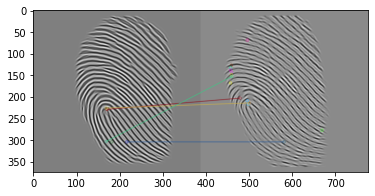

In [94]:
# Show the result using drawMatches
def find_matches(des1, des2, norm=cv2.NORM_HAMMING):
  return match_bruteforce_local(des1, 
                                des2,
                                norm)

def draw_matches(img1, img2, kp1, kp2, matches):
  return cv2.drawMatches(
    img1, kp1,
    img2, kp2, 
    matches, 
    None
  )

matches = find_matches(des1, des2, dd_norm)
plt.imshow(draw_matches(image_enhanced_1, 
                        image_enhanced_2, 
                        kp1, 
                        kp2, 
                        matches))
plt.show()

#### 4.3 Global matching by testing geometrical consistency

[Here](https://www.learnopencv.com/image-alignment-feature-based-using-opencv-c-python/) you can find a description and code how to start from the brute force matching results and estimate the best transformation (from a family of transformations) that aligns the two images. In the example given [here](https://www.learnopencv.com/image-alignment-feature-based-using-opencv-c-python/), a homography-type transformation is searched for. However, this has too many degrees of freedom for our application. We substituted this by a more constrained (only 4 degrees of freedom) similarity (partial affine) transformation.
These routines iteratively determine the minimal set of matching points that define a transformation that optimally aligns all other points as well, taking care of outliers at the same time. This method is a very general optimization technique and is called RANSAC, for "RANdom SAmple Consensus". See, apart from many other sources on the internet, [this presentation](http://www.cse.psu.edu/~rtc12/CSE486/lecture15.pdf) for further explanation. 

In [0]:
def match_bruteforce_global(kp1, 
                            kp2, 
                            matches, 
                            good_match_percent = 0.75):
    # A local function required to transform key_points by a certain 
    #   transformation matrix
    def transform_keypoints(key_points, transformation_matrix):
        # convert keypoint list to Nx1x2 matrix
        mat_points = cv2.KeyPoint.convert(key_points).reshape(-1,1,2)
        # transform points 
        mat_reg_points = cv2.transform(mat_points, transformation_matrix)
        # return transformed keypoint list
        return cv2.KeyPoint.convert(mat_reg_points)    

    # Select the best x percent best matches (on local feature vector 
    #   level)  for further global comparison.
    numGoodMatches = int(len(matches) * good_match_percent)
    good_matches = matches[:numGoodMatches]
   
    # Retain only the keypoints associated to the best matches 
    src_pts = np.float32(
        [kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32(
        [kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    
    # Estimate an optimal 2D affine transformation with 4 degrees of 
    #   freedom, limited to combinations of translation, rotation, and 
    #   uniform scaling.
    # This is the core of the global consistency check: if we find the 
    #   correct transformation (which we expect for genuine pairs and 
    #   not for imposter pairs), we can use it as an additional check by 
    #   verifying the geometrical quality of the match
    
    # M stores the optimal transformation
    #   inliers stores the indices of the subset of points that were 
    #   finally used to calculate the optimal transformation
    M, inliers = cv2.estimateAffinePartial2D(src_pts, 
                                             dst_pts, 
                                             method=cv2.RANSAC, 
                                             confidence=0.9, 
                                             ransacReprojThreshold=10.0, 
                                             maxIters=5000, 
                                             refineIters=10)
    
    # Get the inlier matches
    matched = [x for x,y in zip(good_matches, inliers) if y[0] == 1]

    # The optimal transformation is only correct for genuine pairs in 
    #   about 75% of cases (experimentally on dataset DB1).
    # One can build additional checks about the validity of the 
    #   transformation, e.g. too large translations, rotations and/or 
    #   scale factors.
    
    # A simple one is to test the number of keypoints that were used 
    #   in calculating the transformation. 
    # If this number is is too small, then the transformation is 
    #   most possibly unreliable. 
    # In that case, we reset the transformation to the identity
    if np.sum(inliers) < 5:
        M = np.eye(2, 3, dtype=np.float32)

    # Transform the first keypoint set using the transformation M
    kp1_reg = transform_keypoints(kp1, M)
                                              
    return kp1_reg, matched, M

In [0]:
kp1_reg, matched, M = match_bruteforce_global(kp1,
                                              kp2, 
                                              matches, 
                                              good_match_percent = 0.75)

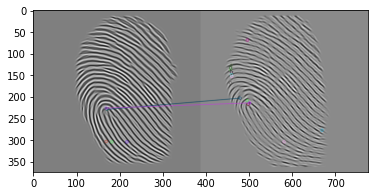

Affine_#inliers:2


<Figure size 432x288 with 0 Axes>

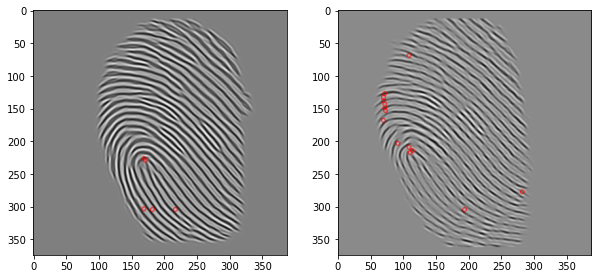

In [98]:
# Visualization of the matches after affine transformation.
height, width = image_enhanced_2.shape[:2]
im1Reg = cv2.warpAffine(image_enhanced_1, M, (width, height))

# Only the inlier matches (matched) are shown.
plt.imshow(draw_matches(im1Reg, image_enhanced_2, kp1_reg, kp2, matched)) 
plt.show()

# Note; the hypothesis is that the transformation will be most of the 
#   time OK for genuine pairs, but wrong for imposter pairs. 

# Show all keypoints after geometric matching
print("Affine_#inliers:{}".format(len(matched)))
ax = plt.figure()
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(10,10))
ax[0].imshow(draw_keypoints(im1Reg, kp1_reg))
ax[1].imshow(draw_keypoints(image_enhanced_2, kp2))
plt.show()

## TASKS

Implement the following tasks for one of the 4 databases. I suggest either DB1 or DB2, since they seem a little easier.

#### Task 1 Test different Keypoint Detectors/Descriptors

* OpenCV provides different KeyPoint detectors and descriptors (ORB, SIFT, SURF, BRIEF, ...). Briefly test, visually, which of these seem to extract relatively reliable interesting points from the fingerprints.
* Note that for some of the KeyPoint descriptors, you need to have a special licence or a full implementation. Skip if you do not have it.
* You also may have to tune the parameters of these detectors.
* But don't spend too much time on this testing step. 
* If you do have the time and the computational resources, you can compare not just visually but by calculating all through using ROC and CMC curves as evidence (Cf. task 3)

In [0]:
for dd_name in ['ORB', 'SIFT', 'SURF', 'BRIEF', 'BRISK']:
  

#### Task 2. Determine a matching function
    
You have been given code to calculate matches on a local level and to calculate an affine transformation that allows a more global consistency check. 
    
Define and test different matching functions that make use of these two-level features.
    
1. a function based only on the local features (e.g. number of pairs with feature distance below a set distance threshold, the sum or mean of the feature distance of the best N pairs, or any other function you think is a good candidate)
2. a function based on the geometrical distances between pairs of KeyPoints are affine transformation. For instance, you can take again a brute force matcher that, instead of pairwise feature descriptor distances, computes pairwise geometrical distances between the two point sets. From there on you can then define different measures (number of below a threshold or sum/mean of distances, ...). You can also limit the number of point pairs to apply this to to the matching pairs that result from the local match and/or the ones that are returned as 'matched' by the Ransac procedure. 
3. any combination of local and global match metrics

#### Task 3 Test complete system for authentication and identification scenario's

* Choose (at least) one of the databases provided
* calculate the ROC (false match to false non match rate) for an authentication scenario 
* and a Cumulative Match Characteristic (CMC) curve, which plots the rank (order in the candidate list) on the x-axis and the probability of identification at that or better rank on the y-axis. Feel free to reuse your code of the previous assignment!

* Of course you can calulate and store the features upfront before starting the validation procedures.
* Also follow the pipeline and the datastructure of the first assignment on validation, where you calculated genuine and imposter scores (cf. the genuine_id and scores lists that you generated)

#### Task 4 Discuss your results
    
* which parts are critical?
* given more time, how would you improve?
* compare your results to the results that are available [online](http://bias.csr.unibo.it/fvc2002/results.asp) 